![background.png](https://www.vifindia.org/sites/default/files/terrorism-gold-text-black-background-d-rendered-royalty-free-stock-picture-image-can-be-used-online-website-banner-87918799.jpg)

---
# **Analysis and Predictive Modelling of global terrorism attack success or failure**
---
> The primary objective of this project is to anlayze global terrorism trends draw insightful conclusions from the data on terrorist attack patterns and build a predictive model that will predict the probability of success of terrorist attacks.

>The model will utilize historical data on previous attacks, which include factors such as

>>```
country, city, region, attack type,
weapon type, target type, attack duration greater than 24 hours or less,
whether a kid was held hostage, group name,
and if the attack was single or multiple.
```
>>
to identify patterns which determines which attack is most likely to be succesful and thus advice on necessary action to take.



In [3]:
#@title Library Imports
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import warnings
from sklearn.impute import SimpleImputer
from IPython.display import display, HTML     #for scrollable view

warnings.filterwarnings("ignore")
pd.set_option('display.max_info_rows', 1000)
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
plt.style.use('ggplot')
sns.set_context('notebook')

In [4]:
#@title Download Dataset
# download dataset
!gdown 1-9nJNjjY6M9HZh5tALNXjz_2c45vGmZo

Downloading...
From: https://drive.google.com/uc?id=1-9nJNjjY6M9HZh5tALNXjz_2c45vGmZo
To: /content/globalterrorismdb_0718dist.csv
100% 163M/163M [00:05<00:00, 32.4MB/s]


In [5]:
#@title Detect file Encoding
# detect file encoding
with open('globalterrorismdb_0718dist.csv', 'rb') as raw:
  result=chardet.detect(raw.read(90000))
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [6]:
# Abdul Basit
#function for scrollable view

def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html



In [7]:
#@title Load and Display Data
terrorism_df= pd.read_csv('globalterrorismdb_0718dist.csv', encoding="ISO-8859-1")

raw_data = create_scrollable_table(terrorism_df.head(20),'raw_dataset', 'Global Terrorism Data Raw Data')
display(HTML(raw_data))


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, consulate)",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,

In [8]:
# Abdul Basit
data_description = create_scrollable_table(terrorism_df.describe(), 'numerical_features', 'Description of the dataset')
display(HTML(data_description))

,eventid,iyear,imonth,iday,extended,country,region,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,doubtterr,alternative,multiple,success,suicide,attacktype1,attacktype2,attacktype3,targtype1,targsubtype1,natlty1,targtype2,targsubtype2,natlty2,targtype3,targsubtype3,natlty3,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claim2,claimmode2,claim3,claimmode3,compclaim,weaptype1,weapsubtype1,weaptype2,weapsubtype2,weaptype3,weapsubtype3,weaptype4,weapsubtype4,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,nhostkid,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
count,1.816910e+05,181691.000000,181691.000000,181691.000000,181691.000000,181691.000000,181691.000000,177135.000000,1.771340e+05,181685.000000,181691.000000,181691.000000,181691.000000,181691.000000,181690.000000,29011.000000,181690.000000,181691.000000,181691.000000,181691.000000,6314.000000,428.000000,181691.000000,171318.000000,180132.000000,11144.000000,10685.000000,10828.000000,1176.000000,1097.000000,1147.000000,181311.000000,1955.000000,320.000000,181691.000000,110576.000000,112202.000000,115571.000000,19083.000000,1890.000000,616.000000,318.000000,133.000000,4839.000000,181691.000000,160923.000000,13127.000000,11542.000000,1863.000000,1693.000000,73.000000,70.000000,171378.000000,117245.000000,114733.000000,165380.000000,116989.000000,112548.000000,181691.000000,64065.000000,3.898900e+04,181513.000000,13572.000000,13517.000000,4063.000000,8124.000000,77381.000000,1.350000e+03,5.630000e+02,7.740000e+02,552.000000,10991.000000,10400.000000,181691.000000,181691.000000,181691.000000,181691.000000
mean,2.002705e+11,2002.638997,6.467277,15.505644,0.045346,131.968501,7.160938,23.498343,-4.586957e+02,1.451452,0.068297,0.988530,0.993093,0.875668,-0.523171,1.292923,0.137773,0.889598,0.036507,3.247547,3.719512,5.245327,8.439719,46.971474,127.686441,10.247218,55.311652,131.179442,10.021259,55.548769,144.564952,0.081440,0.265473,0.193750,0.002950,-65.361154,-1.517727,0.049666,7.022848,0.247619,7.176948,0.411950,6.729323,-6.296342,6.447325,11.117162,6.812524,10.754029,6.911433,11.643237,6.246575,10.842857,2.403272,0.045981,0.508058,3.167668,0.038944,0.107163,-0.544556,3.295403,2.088119e+05,0.059054,4.533230,-0.353999,-46.793933,-32.516371,-0.145811,3.172530e+06,5.784865e+05,7.179437e+05,240.378623,4.629242,-29.018269,-4.543731,-4.464398,0.090010,-3.945952
std,1.325957e+09,13.259430,3.388303,8.814045,0.208063,112.414535,2.933408,18.569242,2.047790e+05,0.995430,0.284553,0.106483,0.082823,0.329961,2.455819,0.703729,0.344663,0.313391,0.187549,1.915772,2.272023,2.246642,6.653838,30.953357,89.299120,5.709076,25.640310,125.951485,5.723447,26.288955,163.299295,0.273511,0.441698,0.395854,0.054234,216.536633,12.830346,1.093195,2.476851,0.974018,2.783725,0.492962,2.908003,4.234620,2.173435,6.495612,2.277081,7.594574,2.177956,8.493166,1.507212,8.192672,11.545741,5.681854,4.199937,35.949392,3.057361,1.488881,3.122889,0.486912,1.552463e+07,0.461244,202.316386,6.835645,82.800405,121.209205,1.207861,3.021157e+07,7.077924e+06,1.014392e+07,2940.967293,2.035360,65.720119,4.543547,4.637152,0.568457,4.691325
min,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,4.000000,1.000000,-53.154613,-8.618590e+07,1.000000,-9.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-99.000000,-99.000000,-9.000000,1.000000,-9.000000,1.000000,0.000000,1.000000,-9.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,-9.900000e+01,-9.000000,-99.000000,-99.000000,-99.000000,-99.000000,-9.000000,-9.900000e+01,-9.900000e+01,-9.900000e+01,-99.000000,1.000000,-99.000000,-9.000000,-9.000

---

## **Data Cleaning**

---



In [9]:
# print dataset number of rows and columns
terrorism_df.shape

(181691, 135)

> There are 135 features and 181,691 observations in the dataset.


---
#### ***Subset the data for the variables of interest***

Furthermore, as regards the project objective, we will subset the original dataset for only the features we consider relevant to our objective. This is based on information gained from the dataset description.

In [10]:
project_df = terrorism_df[['iyear', 'imonth', 'iday', 'country_txt',
                           'region_txt','extended', 'city', 'multiple',
                           'success', 'attacktype1_txt',
                           'targtype1_txt','weaptype1_txt',
                           'ishostkid', 'gname']]

# Abdul Basit
project_data = create_scrollable_table(project_df.head(50),'dataset', 'Global Terrorism Data')
display(HTML(project_data))

,iyear,imonth,iday,country_txt,region_txt,extended,city,multiple,success,attacktype1_txt,targtype1_txt,weaptype1_txt,ishostkid,gname
0,1970,7,2,Dominican Republic,Central America & Caribbean,0,Santo Domingo,0.0,1,Assassination,Private Citizens & Property,Unknown,0.0,MANO-D
1,1970,0,0,Mexico,North America,0,Mexico city,0.0,1,Hostage Taking (Kidnapping),Government (Diplomatic),Unknown,1.0,23rd of September Communist League
2,1970,1,0,Philippines,Southeast Asia,0,Unknown,0.0,1,Assassination,Journalists & Media,Unknown,0.0,Unknown
3,1970,1,0,Greece,Western Europe,0,Athens,0.0,1,Bombing/Explosion,Government (Diplomatic),Explosives,0.0,Unknown
4,1970,1,0,Japan,East Asia,0,Fukouka,0.0,1,Facility/Infrastructure Attack,Government (Diplomatic),Incendiary,0.0,Unknown
5,1970,1,1,United States,North America,0,Cairo,0.0,1,Armed Assault,Police,Firearms,0.0,Black Nationalists
6,1970,1,2,Uruguay,South America,0,Montevideo,0.0,0,Assassination,Police,Firearms,0.0,Tupamaros (Uruguay)
7,1970,1,2,United States,North America,0,Oakland,0.0,1,Bombing/Explosion,Utilities,Explosives,0.0,Unknown
8,1970,1,2,United States,North America,0,Madison,0.0,1,Facility/Infrastructure Attack,Military,Incendiary,0.0,New Year's Gang
9,1970,1,3,United States,North America,0,Madison,0.0,1,Facility/Infrastructure Attack,Government (General),Incendiary,0.0,New Year's Gang


#### ***Rename Columns***

In [11]:
#MUHEENAT
# rename the columns to a more human readable form

column_names = {'iyear':'year', 'imonth':'month', 'iday':'day', 'country_txt':'country_name',
                'region_txt':'region_name', 'extended': 'Duration>24hrs',
                'attacktype1_txt':'attacktype', 'multiple':'ismultiple',
                'targtype1_txt':'targettype_name', 'gname':'group_name',
                'weaptype1_txt':'weapontype_name', 'ishostkid':'kid_is_hostage'}
project_df.rename(columns=column_names, inplace=True)
print(project_df.shape)
# Abdul Basit
project_data = create_scrollable_table(project_df.head(50),'renamed_dataset', 'Columns are renamed')
display(HTML(project_data))

(181691, 14)


,year,month,day,country_name,region_name,Duration>24hrs,city,ismultiple,success,attacktype,targettype_name,weapontype_name,kid_is_hostage,group_name
0,1970,7,2,Dominican Republic,Central America & Caribbean,0,Santo Domingo,0.0,1,Assassination,Private Citizens & Property,Unknown,0.0,MANO-D
1,1970,0,0,Mexico,North America,0,Mexico city,0.0,1,Hostage Taking (Kidnapping),Government (Diplomatic),Unknown,1.0,23rd of September Communist League
2,1970,1,0,Philippines,Southeast Asia,0,Unknown,0.0,1,Assassination,Journalists & Media,Unknown,0.0,Unknown
3,1970,1,0,Greece,Western Europe,0,Athens,0.0,1,Bombing/Explosion,Government (Diplomatic),Explosives,0.0,Unknown
4,1970,1,0,Japan,East Asia,0,Fukouka,0.0,1,Facility/Infrastructure Attack,Government (Diplomatic),Incendiary,0.0,Unknown
5,1970,1,1,United States,North America,0,Cairo,0.0,1,Armed Assault,Police,Firearms,0.0,Black Nationalists
6,1970,1,2,Uruguay,South America,0,Montevideo,0.0,0,Assassination,Police,Firearms,0.0,Tupamaros (Uruguay)
7,1970,1,2,United States,North America,0,Oakland,0.0,1,Bombing/Explosion,Utilities,Explosives,0.0,Unknown
8,1970,1,2,United States,North America,0,Madison,0.0,1,Facility/Infrastructure Attack,Military,Incendiary,0.0,New Year's Gang
9,1970,1,3,United States,North America,0,Madison,0.0,1,Facility/Infrastructure Attack,Government (General),Incendiary,0.0,New Year's Gang


#### ***Check Dtype and Column with null features***

In [12]:
# check data type of every feature
project_df.dtypes

year                 int64
month                int64
day                  int64
country_name        object
region_name         object
Duration>24hrs       int64
city                object
ismultiple         float64
success              int64
attacktype          object
targettype_name     object
weapontype_name     object
kid_is_hostage     float64
group_name          object
dtype: object

In [13]:
#  check for columns contaning null values
null_columns = project_df.isnull().sum().loc[lambda x : x > 0]
print(null_columns.sort_values())
print("Number of null columns: ", len(null_columns))

ismultiple          1
kid_is_hostage    178
city              434
dtype: int64
Number of null columns:  3


> There are 3 out 19 columns in the dataset with null values.



#### ***Imputation of missing values***

In [14]:
# multiple or single attack
print(project_df.ismultiple.value_counts())

0.0    156658
1.0     25032
Name: ismultiple, dtype: int64


In [15]:
# kid_is_hostage
print(project_df.kid_is_hostage.value_counts())

 0.0    167624
 1.0     13572
-9.0       317
Name: kid_is_hostage, dtype: int64


In [16]:
# city
print(project_df.city.value_counts())

Unknown      9775
Baghdad      7589
Karachi      2652
Lima         2359
Mosul        2265
             ... 
Hotwag          1
Ostend          1
Balughata       1
Jikoyi          1
Kubentog        1
Name: city, Length: 36674, dtype: int64


The following can be observed upon inspecting the values in the columns with the missing values:

1. The most frequent value in the 'ismultiple' column is '0.0'
2. The most frequent value in the 'kid_is_hostage' column is '0.0'
3. The 'kid_is_hostage' contains a minority group of '-9.0' this will later be filled in with the most frequent value.
4. The most frequent value in the 'city' column is 'Unknown'

In [17]:
# imputation of null values using sklearn simpleimputer library
# and using the 'most_frequent' strategy

# instantiate the imputer
imputer_most_frequent = SimpleImputer(strategy='most_frequent',
                                      missing_values=np.nan)
# transform the null columns
null_series=imputer_most_frequent.fit_transform(
    project_df[list(null_columns.index)])
# set the original values to the transformed values
project_df[list(null_columns.index)] = null_series

In [18]:
# check that there are no longer
# columns with missing values
project_df.isnull().any()

year               False
month              False
day                False
country_name       False
region_name        False
Duration>24hrs     False
city               False
ismultiple         False
success            False
attacktype         False
targettype_name    False
weapontype_name    False
kid_is_hostage     False
group_name         False
dtype: bool

#### ***Fix dtypes and invalid values***
The following cleaning will be carried out in this section

1. Data types of multiple_or_single and kid_is_hostage will be changed to int64 from float
2. The minority '-9' value in the kid_is_hostage feature will be replaced with '0'

In [19]:
# change dtype from float to int
# of kid_is_hostage and multiple_or_single
project_df['kid_is_hostage'] = project_df['kid_is_hostage'].astype(np.int64)
project_df['ismultiple'] = project_df['ismultiple'].astype(np.int64)

In [20]:
# check
project_df[['ismultiple', 'kid_is_hostage']].dtypes

ismultiple        int64
kid_is_hostage    int64
dtype: object

In [21]:
# replace minority value '-9' with 0
project_df.loc[project_df['kid_is_hostage']== -9, 'kid_is_hostage'] = 0
project_df['kid_is_hostage'].value_counts()

0    168119
1     13572
Name: kid_is_hostage, dtype: int64

---

## **Exploratory Data Analysis**

---

#### ***Univariate Exploration***
In this section, we will be exploring the distributions of values in the features we have chosen to focus on.
>*Target Feature(Success)*

In [22]:
def annotate_without_hue_percent(ax, feature):
  """
  Annotates the bars of a countplot
  without the hue parameter with percentages
  with percentages of their value

  Credit: stackoverflow link(https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-grouped-bars)
  """
  total = len(feature)
  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

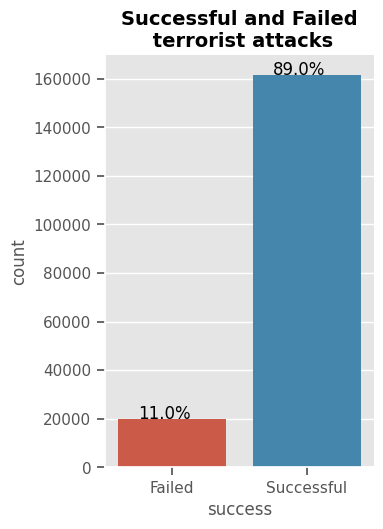

In [23]:
#carla
g=sns.catplot(x = "success", data= project_df, kind='count', height=5, aspect=0.8)
g.set_xticklabels({'Failed':0, 'Successful':1})
g.ax.set_title("Successful and Failed\n terrorist attacks", fontsize=14, fontweight=700);
annotate_without_hue_percent(g.ax, project_df.success)
plt.gca().figure.savefig("success.png", dpi=1080, bbox_inches='tight')

There are more successful attacks (89%) in the data than failed attacks (11%). This could lead to a bias in the classification of attacks. To handle this we will look into some of the techniques mentioned [here](https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#:~:text=Imbalanced%20data%20refers%20to%20those,very%20low%20number%20of%20observations.) and choose an appropriate one for our project.

> The following features will be explored in this section

1. Duration>24hrs (If attack duration was greater than 24hrs or not)
2. ismultiple (Was the attack a single attack or multiple attack)
3. kid_is_hostage (Was a kid held hostage)

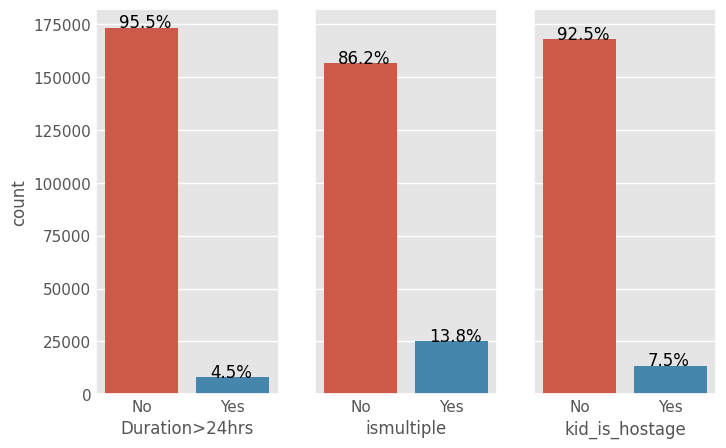

In [24]:
fig, axes=plt.subplots(1, 3, figsize=(8, 5), sharey=True)
for ax, col_name in zip(axes, ['Duration>24hrs', 'ismultiple', 'kid_is_hostage']):
  sns.countplot(data=project_df, x=col_name, ax=ax)
  ax.tick_params(axis=u'both', which=u'both',length=0)
  ax.set_xticklabels(['No', 'Yes'])
  if col_name in ['ismultiple', 'kid_is_hostage']:
    ax.set_ylabel("")
  annotate_without_hue_percent(ax=ax, feature=project_df[col_name])
fig.savefig("duration_mult_host.png", dpi=1080, bbox_inches='tight')

Most terrorist attacks in our dataset have the following in common:

1. The duration  leisss than 24hrs.
2. They are mostly single attacks.
3. No Kid was held hostage in 93% of the attacks.
4. Most of the attacks are successful.

> **Which Region, Country and City have the highest number of terrorist attacks?**

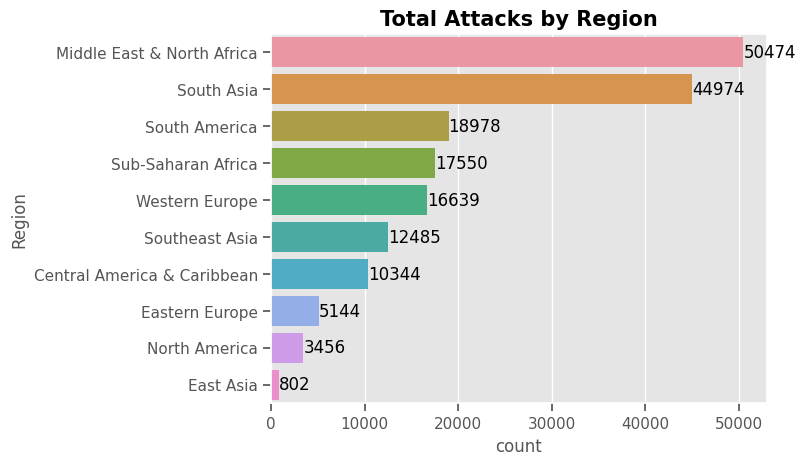

In [25]:
def plot_column_value_count(df, column_name):
  """This function takes in  a dataframe and
     column name and plots a bar chart of the
     count of values for the top 20 values
     in that column.

     Input:
      df: pandas dataframe
      column_name: Name of column to plot the bar chart for.
  """
  column_title = column_name.split('_')[0].title()
  # carla   #Muheenat - I changed the title of the graph from Top 20 region to Total Attacks by Region.
  # count the values
  graph=df[column_name].value_counts().to_frame(name='count').reset_index().head(10)
  graph.rename(columns = {'index':column_title}, inplace = True)

  # customize the plot
  ax = sns.barplot(x='count', y=column_title, data=graph)
  ax.set_title(f"Total Attacks by {column_title}", fontsize=15, fontweight=700)
  for container in ax.containers:
      ax.bar_label(container)

plot_column_value_count(project_df, 'region_name')
plt.gca().figure.savefig("total_attack_count_by_region.png", dpi=1080, bbox_inches='tight')

Middle East and North Africa followed by South Asia have the highest number (500474 and 44974 respectively) of terrorist attacks.


Now we are going to visualize the top 10 most attacked countries and cities.

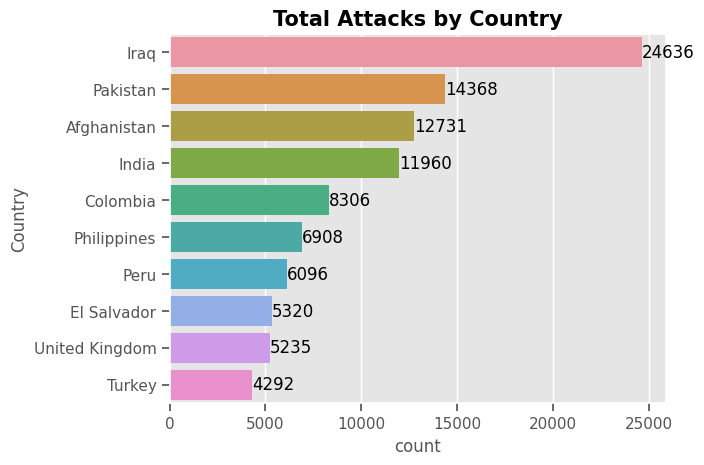

In [26]:
#carla
plot_column_value_count(project_df, 'country_name')
plt.gca().figure.savefig("total_attack_count_by_country.png", dpi=1080, bbox_inches='tight')

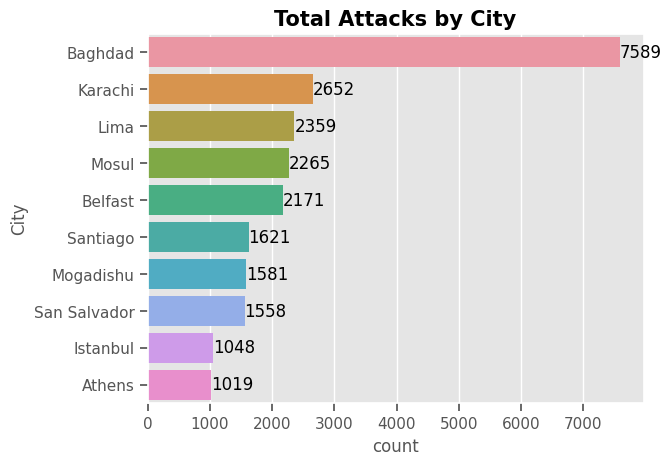

In [27]:
#carla
plot_column_value_count(project_df[project_df.city != "Unknown"], 'city')

In conclusion, as of 2017, the terrorist attack is most common in the Middle East and South Asia in the country of Iraq and Pakistan and the city of Baghdad. Though in [recent](https://en.wikipedia.org/wiki/January_2021_Baghdad_bombings) years, terrorist attacks seem to be dropping in frequency.

> **Which is the most common target type, attack type and group?**

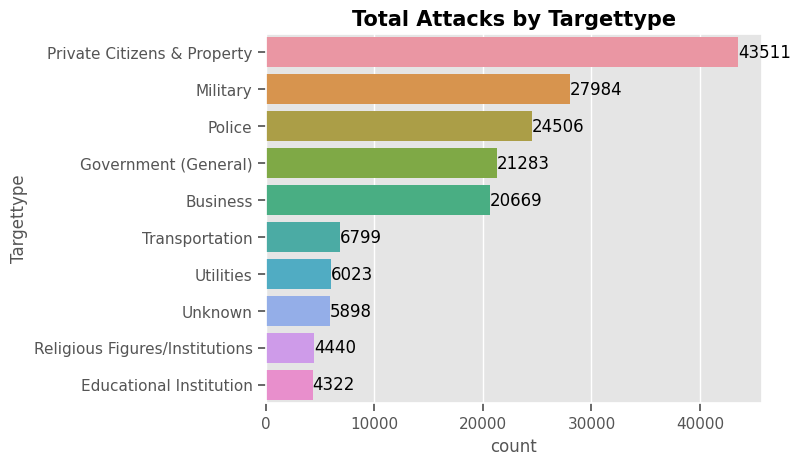

In [28]:
plot_column_value_count(project_df, 'targettype_name')
plt.gca().figure.savefig("total_attack_count_by_target.png", dpi=1080, bbox_inches='tight')

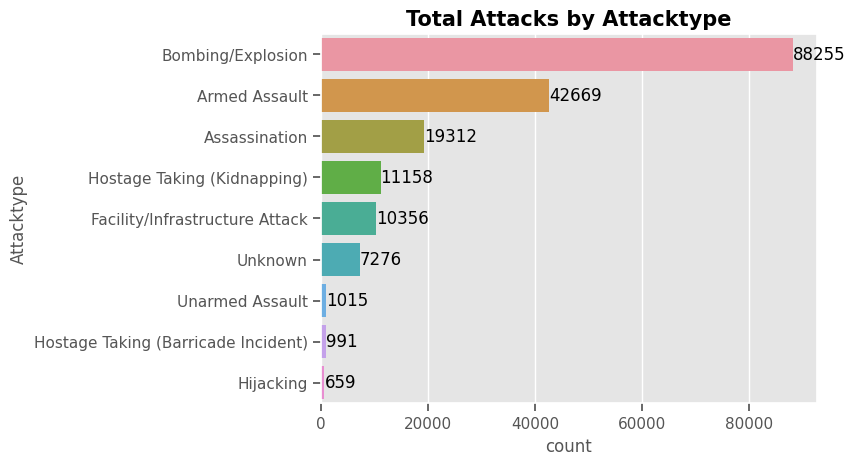

In [29]:
plot_column_value_count(project_df, 'attacktype')
plt.gca().figure.savefig("total_attack_count_by_attack.png", dpi=1080, bbox_inches='tight')

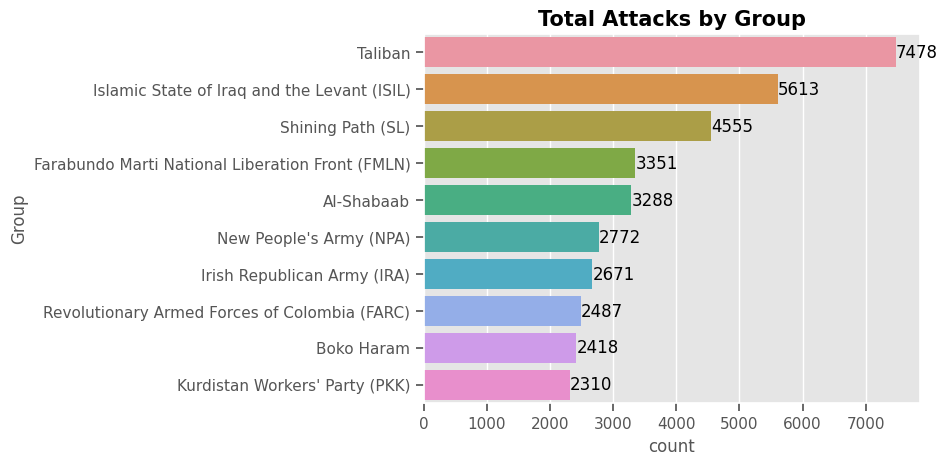

In [30]:
plot_column_value_count(project_df[project_df.group_name != 'Unknown'], 'group_name')
plt.gca().figure.savefig("total_attack_count_by_group.png", dpi=1080, bbox_inches='tight')

> **Which group have the highest rate of successful attacks?**

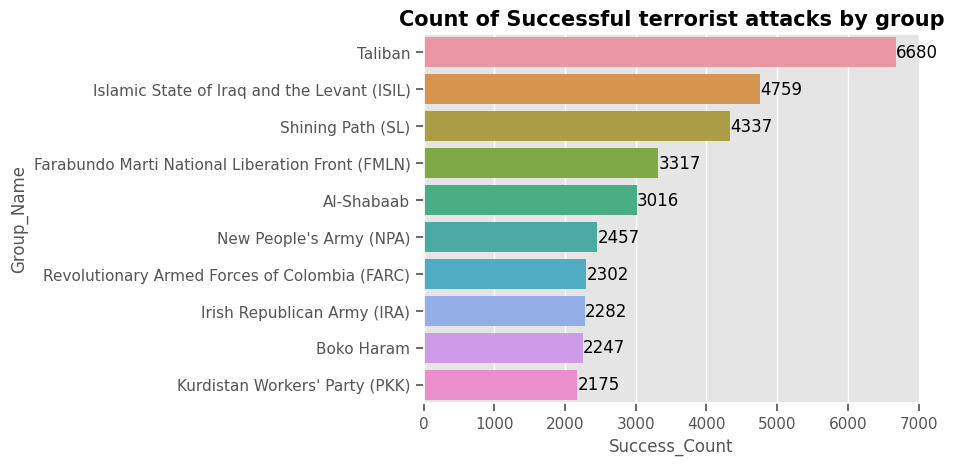

In [31]:
graph_data=pd.DataFrame(project_df.query("success==1")['group_name'].value_counts().reset_index())
graph_data.rename(columns={'index': 'Group_Name', 'group_name': 'Success_Count'}, inplace=True)
graph_data=graph_data.query('Group_Name != "Unknown"').head(10)

ax=sns.barplot(data=graph_data, x='Success_Count',
              y='Group_Name')
ax.set_title("Count of Successful terrorist attacks by group",  fontsize=15, fontweight= 700)
for container in ax.containers:
  ax.bar_label(container)
ax.figure.savefig("attack_count_by_group.png", dpi=1080, bbox_inches='tight')

The most common terrorist ***attack type, target type, group, and the group with the highest number of success*** are ***Bombing and explosion, Private Citizens and property, Taliban and Taliban*** respectively.

#### ***Bivariate and Multivariate Exploration***


>**How has terrorist attacks increased or decreased between the year 1970 to 2017?**

In [32]:
# carla (modified)
def plot_trends_by_year(column_name):
  """
  This function takes a column name
  and plot the trend for that feature
  between the year 1970 to 2017

  Input
        column_name: feature to plot
  Return
        fig: A plotly figure object for further customization
            of the plot
  """

  graph_plot=project_df.query(f"{column_name} != 'Unknown'")
  graph_plot=graph_plot[[column_name,'year']]\
        .groupby(['year'])[column_name].value_counts()\
        .to_frame(name='total_attacks').reset_index()
  graph_plot = graph_plot.query('total_attacks>=150')

  fig = px.line(graph_plot, x='year', y='total_attacks',
          color=column_name, symbol=column_name)
  return fig

In [33]:
# ##carla
#carla
fig = plot_trends_by_year('region_name')
fig.update_layout(title="Count of terrorist attacks from\n 1970 to 2017 by region")
fig.show()

From the above, it can be seen that there has been an increase in the number of terrorist attacks in at least five regions over the years with the most notable being South Asia and Middle East&North Africa most especially between the years 2000 to 2014.

A decrease in activity can also be seen from 2014 onward.

***which weapon type have seen increasing use between 1970 and 2017***

In [34]:
#carla
fig = plot_trends_by_year('weapontype_name')
fig.update_layout(title="Weapons type usage from 1970 from 2017")
fig.show()

Explosives and firearms have seen an increasing use compared to other weapons.

***how has terrorist group activities changed between 1970 and 2017***

In [35]:
#carla
fig = plot_trends_by_year('group_name')
fig.update_layout(title="Trends in group activities between 1970 from 2017")
fig.show()

I.S.I.L (Islamic State of Iraq and the Levant), Taliban and Al-Shabab are the most active terrorist groups in recent years with I.S.I.L having launched more attacks overall.

---
## **Modelling**
---

In [36]:
!pip install category_encoders
import category_encoders as ce
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.5 MB/s eta 0:00:00


### **Prepare Data**

In [37]:
# dropping the year month and day columns
project_df = project_df.drop(['year','month', 'day'], axis=1)

In [43]:
# split the data into feature and target variable
model_df = project_df.sample(frac=0.5, random_state=42)

X = model_df.drop(columns = ['success'])
y = model_df['success']


In [40]:
# encode the categorical data using base2 encoder
categorical_cols = ['country_name', 'region_name', 'city','attacktype', 'targettype_name', 'weapontype_name','group_name']
encoder = ce.BaseNEncoder(cols=categorical_cols, return_df=True, base=2)
features_encoded = encoder.fit_transform(X, columns=categorical_cols)

In [44]:
features_encoded.head()

,country_name_0,country_name_1,country_name_2,country_name_3,country_name_4,country_name_5,country_name_6,country_name_7,region_name_0,region_name_1,region_name_2,region_name_3,Duration>24hrs,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,ismultiple,attacktype_0,attacktype_1,attacktype_2,attacktype_3,targettype_name_0,targettype_name_1,targettype_name_2,targettype_name_3,targettype_name_4,weapontype_name_0,weapontype_name_1,weapontype_name_2,weapontype_name_3,kid_is_hostage,group_name_0,group_name_1,group_name_2,group_name_3,group_name_4,group_name_5,group_name_6,group_name_7,group_name_8,group_name_9,group_name_10,group_name_11
83552,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
30191,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
51303,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
73581,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
17703,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, y, test_size=0.2, random_state=42)

In [47]:
#carla
def generate_roc_curve(Xtrain, Xtest, ytrain, ytest):

    # Create a dictionary of classification algorithms
    clfs = ( GaussianNB(),
            LogisticRegression(),
            RandomForestClassifier(random_state=42),
            BalancedBaggingClassifier(random_state=42),
            XGBClassifier()
    )
    fig, ax_roc = plt.subplots(1, 1, figsize=(8,6))
    for clf in clfs:

        # Fit the algorithm on the training data
        clf.fit(Xtrain, ytrain)
        RocCurveDisplay.from_estimator(clf, Xtest, ytest, ax=ax_roc,
                                       name=type(clf).__name__)


# princezuko
def evaluate_classification_algorithm(clf, Xtrain, Xtest, ytrain, ytest):

  # Fit the algorithm on the training data
  clf.fit(Xtrain, ytrain)

  # Generate classification report
  classification_report_result = classification_report(ytest, clf.predict(Xtest))
  print("Classification Report:")
  print(classification_report_result)

  # Generate heatmap confusion matrix
  ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, cmap='Blues')
  plt.title(f"{type(clf).__name__} Confusion Matrix")



### ***Before Oversampling***

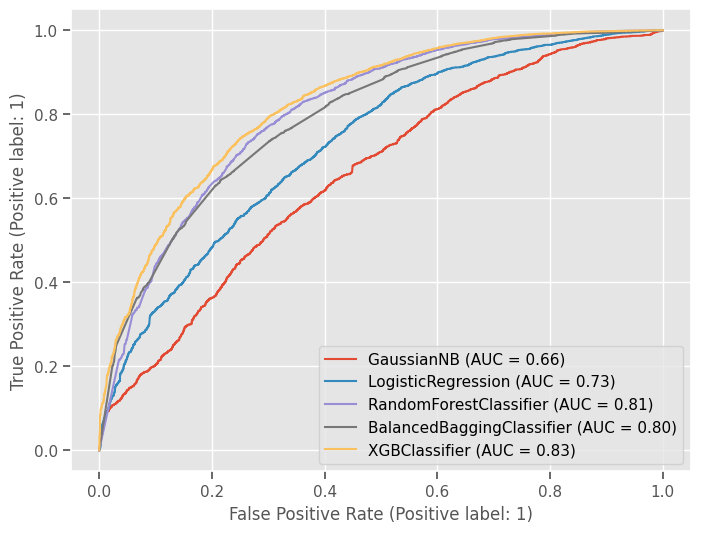

In [48]:
generate_roc_curve(X_train, X_test, y_train, y_test)
plt.gca().figure.savefig("roc_auc_before_balance.png", dpi=1080, bbox_inches='tight')

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.28      0.40      2004
           1       0.92      0.98      0.95     16166

    accuracy                           0.91     18170
   macro avg       0.80      0.63      0.68     18170
weighted avg       0.89      0.91      0.89     18170



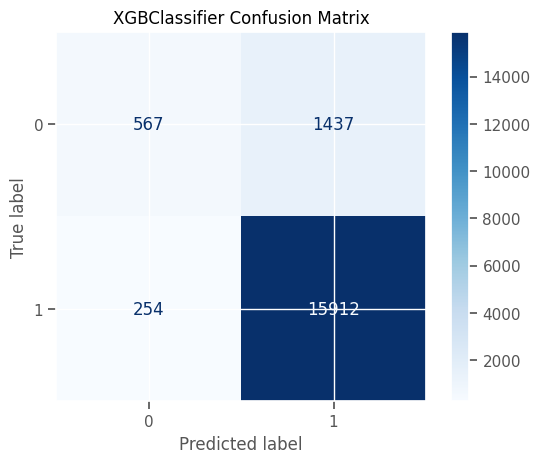

In [49]:
evaluate_classification_algorithm(XGBClassifier(), X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.66      0.37      2004
           1       0.95      0.77      0.85     16166

    accuracy                           0.76     18170
   macro avg       0.60      0.71      0.61     18170
weighted avg       0.87      0.76      0.80     18170



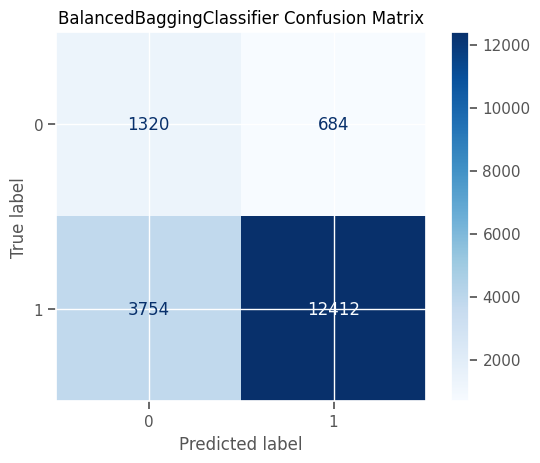

In [50]:
evaluate_classification_algorithm(BalancedBaggingClassifier(random_state=42), X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.30      0.41      2004
           1       0.92      0.98      0.95     16166

    accuracy                           0.90     18170
   macro avg       0.78      0.64      0.68     18170
weighted avg       0.89      0.90      0.89     18170



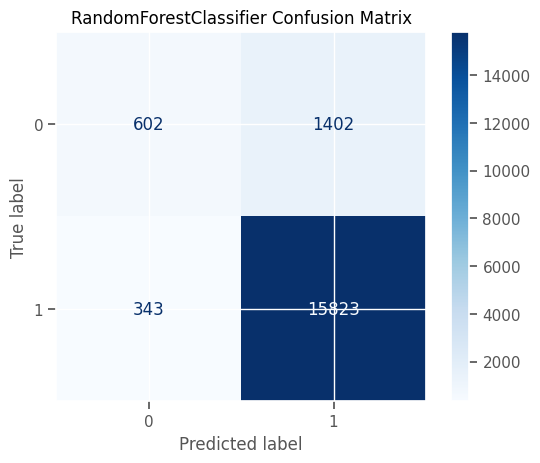

In [51]:
evaluate_classification_algorithm(RandomForestClassifier(random_state=42), X_train, X_test, y_train, y_test)

### ***Oversampling due to imbalance***

In [53]:
from imblearn.over_sampling import SMOTEN

model_smote = SMOTEN(random_state=42, n_jobs = -1)
X_train_smote, y_train_smote = model_smote.fit_resample(X_train, y_train.ravel())

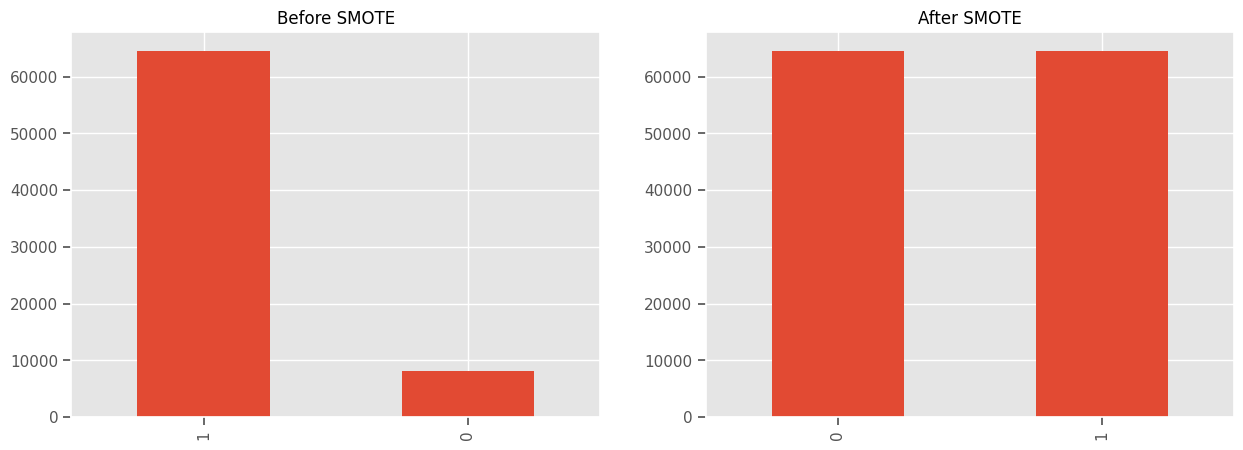

In [54]:
# to demonstrate the effect of SMOTE over imbalanced datasets
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)


ax2.set_title('After SMOTE')
pd.Series(y_train_smote).value_counts().plot.bar(ax=ax2)

plt.show()

#### ***After Oversampling***

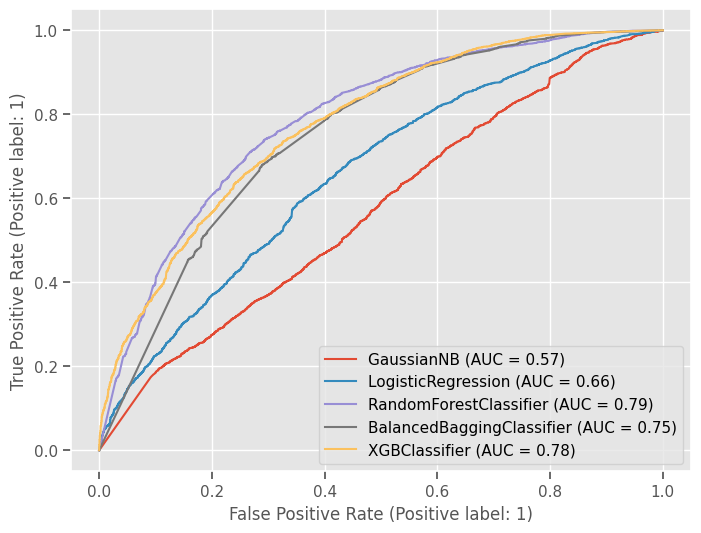

In [55]:
generate_roc_curve(X_train_smote, X_test, y_train_smote.ravel(), y_test)
plt.gca().figure.savefig("roc_auc_after_balance.png", dpi=1080, bbox_inches='tight')

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.49      0.39      2004
           1       0.93      0.87      0.90     16166

    accuracy                           0.83     18170
   macro avg       0.63      0.68      0.65     18170
weighted avg       0.86      0.83      0.85     18170



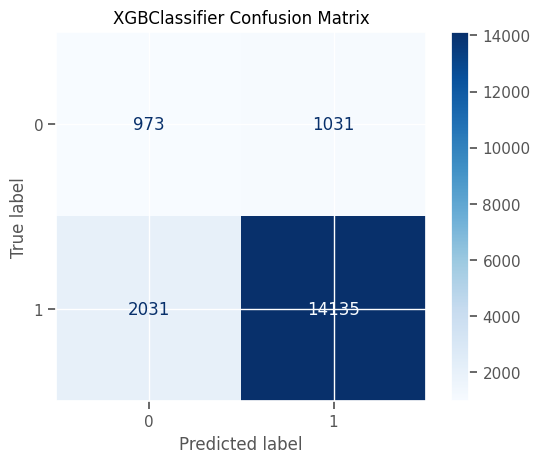

In [56]:
evaluate_classification_algorithm(XGBClassifier(), X_train_smote, X_test, y_train_smote.ravel(), y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.41      0.39      2004
           1       0.93      0.92      0.92     16166

    accuracy                           0.86     18170
   macro avg       0.65      0.66      0.66     18170
weighted avg       0.87      0.86      0.86     18170



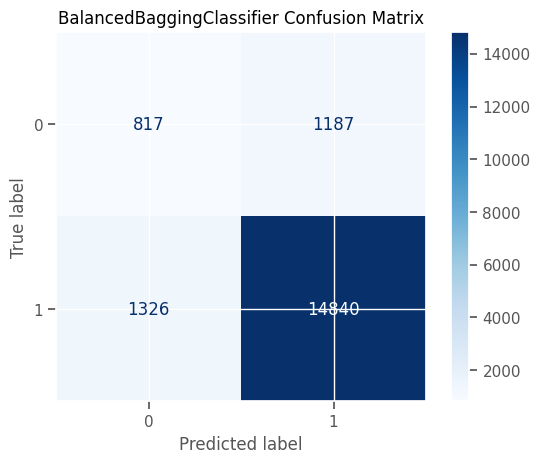

In [57]:
evaluate_classification_algorithm(BalancedBaggingClassifier(random_state=42), X_train_smote, X_test, y_train_smote, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.33      0.38      2004
           1       0.92      0.95      0.93     16166

    accuracy                           0.88     18170
   macro avg       0.68      0.64      0.66     18170
weighted avg       0.87      0.88      0.87     18170



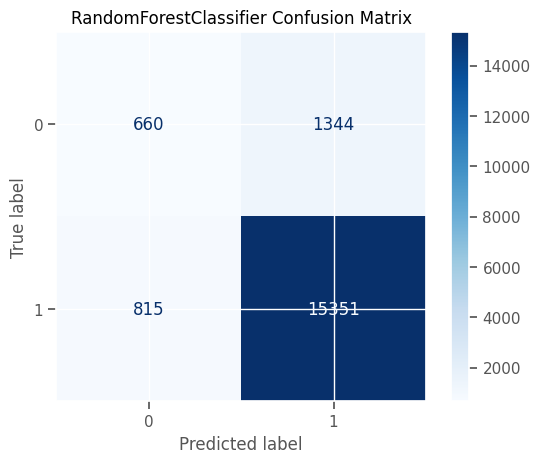

In [58]:
evaluate_classification_algorithm(RandomForestClassifier(random_state=42), X_train_smote, X_test, y_train_smote, y_test)

It can seen that the XGBClassifier generally performs better than the other evaluated models. Also, oversampling with 'SMOTEN' does not have positive effect on the models performance. The XGBClassifier will be tuned further to improve its performance where possible.

### **Model Tuning**

In [59]:
from sklearn.model_selection import RandomizedSearchCV

In [65]:
# parameters tuning (long execution time)
# params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 500, 1000]}
# xgbclf = XGBClassifier(seed = 20)

# clf = RandomizedSearchCV(estimator=xgbclf,
#                          param_distributions=params,
#                          scoring='f1',
#                          n_iter=25,
#                          verbose=1)
# evaluate_classification_algorithm(clf, X_train, X_test, y_train, y_test)
# print("Best parameters:", clf.best_params_)

In [52]:
# best parameters after tuning
best_parameters= {'subsample': 0.7999999999999999,
                  'n_estimators': 100,
                  'max_depth': 10,
                  'learning_rate': 0.1,
                  'colsample_bytree': 0.5,
                  'colsample_bylevel': 0.7999999999999999}

### ***Build model pipeline***

In [60]:
tuned_clf = XGBClassifier(seed=20, **best_parameters)

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
preprocessor = ColumnTransformer(
    transformers =[
        ('encoder', ce.BaseNEncoder(base=2), categorical_cols)
    ]
)

model=make_pipeline(
    preprocessor,
    tuned_clf
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('encoder', BaseNEncoder(),
                                                  ['country_name',
                                                   'region_name', 'city',
                                                   'attacktype',
                                                   'targettype_name',
                                                   'weapontype_name',
                                                   'group_name'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.7999999999999999,
                               colsample_bynode=None, colsample_bytree=...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size=0.3, random_state=42)
evaluate_classification_algorithm(model, Xtrain, Xtest, ytrain, ytest)
plt.gca().figure.savefig("confusion_matrix_final.png", dpi=1080, bbox_inches='tight')

In [ ]:
model.feature_names_in_

### ***Save Model***

In [ ]:
from joblib import dump
dump(model, 'model.joblib')

## **Summary and Conclusion**

From the exploration of the dataset, the following observations were made


1. The duration of most attacks is less than 24hrs.
2. Terrorist attacks are mostly single attacks.
3. No Kid was held hostage in 93% of terrorist attacks recorded.
4. Most of the terrorist attacks recorded were successful.
5. Terrorist attacks are most common in the ***Middle East and South Asia in the country of Iraq and Pakistan and the city of Baghdad***.
6. The most common terrorist ***attack type, target type, group, and the group with the highest number of successes*** are ***Bombing and explosion, Private Citizens and property, Taliban and Taliban*** respectively.


The following trends were observed in terrorist activities, type of weapon used and regions most attacked within the period (1970 to 2017)

1. An increase in the number of terrorist attacks in at least five regions over the years with the most notable being South Asia and Middle East&North Africa most especially between the years 2000 to 2014.

2. A decrease in activity can also be observed from 2014 onward.

3. Explosives and firearms are the most common weapon of choice in the majority of terrorist activities within this period.

4. I.S.I.L (Islamic State of Iraq and the Levant), Taliban and Al-Shabab are the most active terrorist groups in recent years with I.S.I.L having launched more attacks overall.

## **Credit and Thanks**

In [42]:
# We would love to appreciate Hamoye Data Science team for providing this opprotunity to add to our growth and career. Specific recognition to the major contributors of this notebook - Muheenat, Temitayo, Carla, Prince Zuko, Hajara, Chiemela